In [1]:
import cv2
import os
import datetime
import time
import numpy as np
import keras
import tensorflow.keras
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models

# from tensorflow.keras import layers
# import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization 
from tensorflow.keras.layers import SeparableConv2D, Activation,DepthwiseConv2D,Flatten,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpointb
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint


2025-12-05 09:58:03.714282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 09:58:04.157109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 09:58:06.002223: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
labels = ['Newcastle', 'Other abnormal', 'Normal']
class_info = {0: 'Newcastle', 1: 'Other abnormal',2: 'Normal'}
img_size = 224

In [3]:
import glob

filename = glob.glob(r"/mnt/c/Poultry/po datasets/Dataset/Data/Newcastle/*.*")
print(len(filename))

filename = glob.glob(r"/mnt/c/Poultry/po datasets/Dataset/Data/Normal/*.*")
print(len(filename)) 

filename = glob.glob(r"/mnt/c/Poultry/po datasets/Dataset/Data/Other abnormal/*.*")
print(len(filename))


339
1800
3940


In [4]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

In [5]:
def get_data(data_dir, img_size=224):
    x, y = [], []
    
    # List of supported image file extensions
    supported_extensions = ('.bmp','.jpg')
    
    for label in os.listdir(data_dir):
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Check if the file has a supported image extension
                if img.lower().endswith(supported_extensions):
                    img_arr = cv2.imread(os.path.join(path, img))
                    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
                    x.append(resized_arr)
                    y.append(class_num)
            except Exception as e:
                print(e)
    
    return x, y


In [6]:
data_x, data_y = get_data(r"/mnt/c/Poultry/po datasets/Dataset/Data")


In [7]:
test_x, test_y = get_data(r"/mnt/c/Poultry/po datasets/Dataset/Test dataset")
# (r"/mnt/c/Poultry/po datasets/Dataset/Data/Other abnormal/*.*")

In [8]:
from sklearn.model_selection import train_test_split
Train_x, Val_x, Train_y, Val_y = train_test_split(data_x, data_y, test_size=0.2)

In [9]:
Train_x, test_x, Train_y, test_y = train_test_split(Train_x, Train_y, test_size=0.1)

In [10]:
Train_x = np.array(Train_x)
Train_y = np.array(Train_y)
Val_x = np.array(Val_x)
Val_y = np.array(Val_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [11]:
train_datagen = ImageDataGenerator()
val_datagen= ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [12]:
Train_gen  = train_datagen.flow(Train_x, Train_y)
val_gen  = val_datagen.flow(Val_x, Val_y)
test_gen = test_datagen.flow(test_x, test_y)

Text(0.5, 1.0, 'Normal')

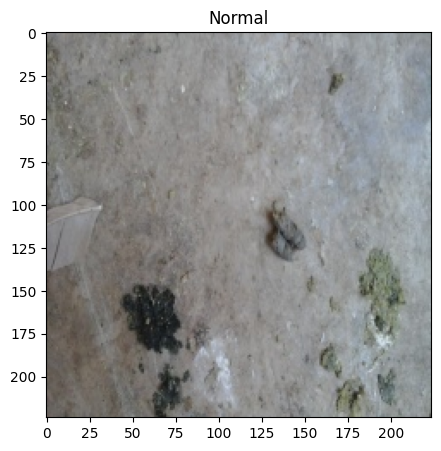

In [13]:
plt.figure(figsize = (5,5))
plt.imshow(Train_x[0])
plt.title(labels[Train_y[0]])

In [14]:
print(Train_x.shape)
print(Val_x.shape)
print(test_x.shape)

(4376, 224, 224, 3)
(1216, 224, 224, 3)
(487, 224, 224, 3)


In [17]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    ResNet50 = tf.keras.applications.ResNet50(
        input_tensor = inputs, 
        weights="imagenet", include_top=False)
    
    x = ResNet50.get_layer('conv5_block3_2_relu').output
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(3,activation='softmax')(x)
    return tf.keras.Model(inputs,output)

In [18]:
model = build_model(input_shape=(224,224,3))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_image[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 22,530,435 (85.95 MB)

 Trainable params: 22,481,411 (85.76 MB)

 Non-trainable params: 49,024 (191.50 KB)

In [19]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, min_lr=1e-8 ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    # tf.keras.callbacks.ModelCheckpoint(
        # filepath='new poultry dataset/classification_weights.h5',
        # save_best_only=True,save_weights_only=False,verbose=1)
           ]

In [20]:
history = model.fit(Train_gen,
                    validation_data = val_gen,
                    epochs=50,
                    batch_size = 8,
                   callbacks=callback)


Epoch 1/50


2025-12-05 10:07:45.634638: I external/local_xla/xla/service/service.cc:163] XLA service 0x74a774001d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-05 10:07:45.634672: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-05 10:07:46.313227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-05 10:07:50.085981: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1764918489.987484    1629 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 100s 443ms/step - accuracy: 0.9374 - loss: 0.2138 - val_accuracy: 0.9128 - val_loss: 0.2997 - learning_rate: 1.0000e-04
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 37s 270ms/step - accuracy: 0.9904 - loss: 0.0445 - val_accuracy: 0.9646 - val_loss: 0.1107 - learning_rate: 1.0000e-04
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.9941 - loss: 0.0271 - val_accuracy: 0.9827 - val_loss: 0.0496 - learning_rate: 1.0000e-04
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.9959 - loss: 0.0182 - val_accuracy: 0.9794 - val_loss: 0.0660 - learning_rate: 1.0000e-04
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 273ms/step - accuracy: 0.9899 - loss: 0.0298 - val_accuracy: 0.9753 - val_loss: 0.0794 - learning_rate: 1.0000e-04
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9926 - loss: 0.0276
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
137/137 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - accu

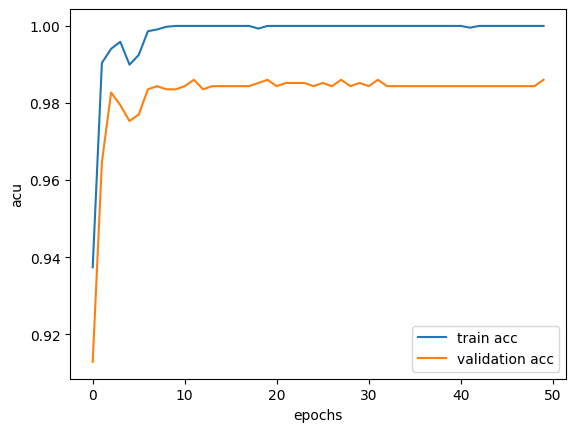

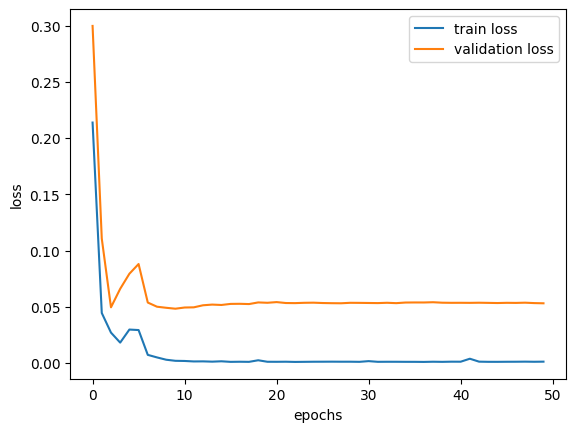

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train acc','validation acc'])
plt.ylabel('acu')
plt.xlabel('epochs')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history[ 'val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [22]:
BATCH = 4
test_dataset = test_datagen.flow(test_x, test_y)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1


model.evaluate(test_dataset, steps=test_steps)

122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9938 - loss: 0.0195  


/home/yordi/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.019470784813165665, 0.9938398599624634]

In [23]:
predictions = model.predict(test_x)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


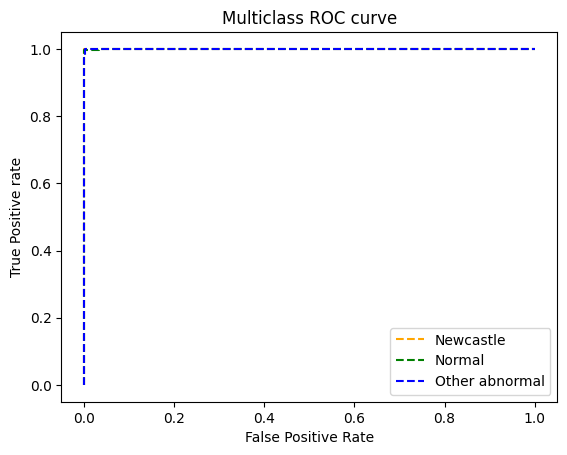

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred_prob = model.predict(test_x)
# pred_prob = restnet.predict_proba(Val_x)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Newcastle')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Normal')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Other abnormal')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [26]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < 0.5, 0, 1)
  return pred.numpy()

class_label_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
['Newcastle', 'Normal', 'Other abnormal']


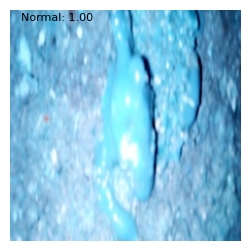

In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = test_x[58]
label = test_y[58]
print('class_label_idx = ', label)
# Make predictions for the input image
predictions = model.predict(np.expand_dims(img, axis=0))[0]
N = 1
# Get the top N predicted classes and their probabilities
top_classes = np.argsort(predictions)[-N:][::-1]
top_probs = predictions[top_classes]

class_labels = ['Newcastle', 'Normal', 'Other abnormal']
print (class_labels)
# Display the image
plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the top predicted classes and their probabilities
for i in range(len(top_classes)):
    class_idx = top_classes[i]
    class_prob = top_probs[i]
    class_label = class_labels[class_idx]
    plt.text(10, 10 + i * 20, f"{class_label}: {class_prob:.2f}", color='Black', fontsize=8)

plt.show()


['Newcastle', 'Normal', 'Other abnormal']
class_Truelabel_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
class_Truelabel_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
class_Truelabel_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
class_Truelabel_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
class_Truelabel_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
class_Truelabel_idx =  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
class_Truelabel_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
class_Truelabel_idx =  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
class_Truelabel_idx =  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
class_Truelabel_idx =  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


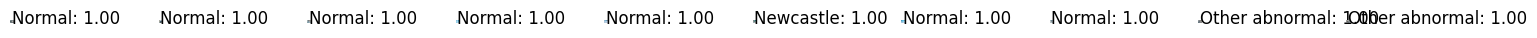

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define a list of images and their corresponding labels
images = test_x[0:10]
labels = test_y[0:10]
class_labels = ['Newcastle', 'Normal', 'Other abnormal']  # Define your class labels
print (class_labels)
# Create a subplot grid
rows = 1  # Only one row for horizontal display
cols = len(images)  # One column per image

plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

# Iterate through each image and label
for i in range(len(images)):
    img = images[i]
    label = labels[i]
    print('class_Truelabel_idx = ', label)
    # Make predictions for the input image
    predictions = model.predict(np.expand_dims(img, axis=0))[0]
    N = 1  # Number of top classes to display

    # Get the top N predicted classes and their probabilities
    top_classes = np.argsort(predictions)[-N:][::-1]
    top_probs = predictions[top_classes]

    # Create a subplot for each image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the top predicted classes and their probabilities below the image
    for j in range(len(top_classes)):
        class_idx = top_classes[j]
        class_prob = top_probs[j]
        class_label = class_labels[class_idx]
        plt.text(0.5, -0.2 - j * 0.2, f"{class_label}: {class_prob:.2f}", color='Black', fontsize=12,
                 transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


In [29]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

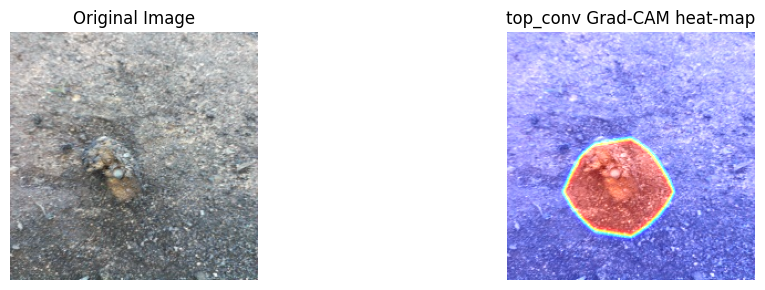

In [33]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'conv5_block3_2_relu'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('top_conv Grad-CAM heat-map')
plt.tight_layout()


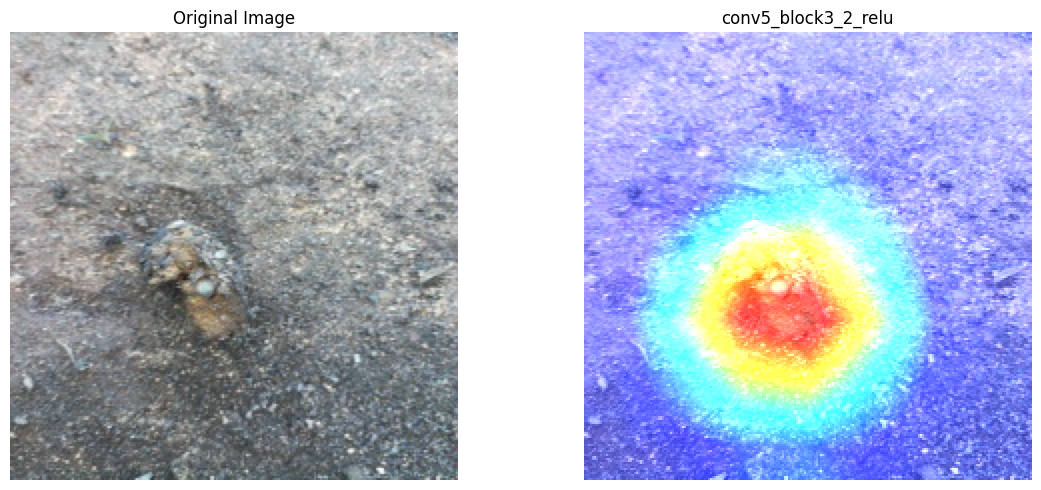

In [35]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(model, np.expand_dims(img, axis=0), 'conv5_block3_2_relu')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('conv5_block3_2_relu')
plt.tight_layout()


Accuracy: 0.993840
Precision: 0.993958
Recall: 0.993840
F1 score: 0.993854
Cohen's kappa: 0.987663
Confusion Matrix:
[[ 25   0   0]
 [  0 305   3]
 [  0   0 154]]


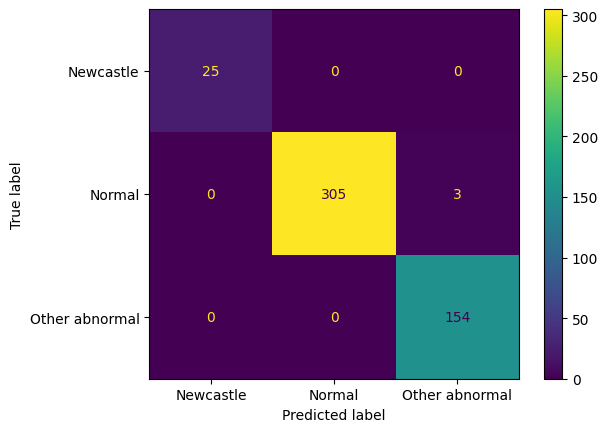

In [36]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import ConfusionMatrixDisplay


# Assuming you have already trained and have your model defined as 'model'

# Predict probabilities for test set
yhat_probs = model.predict(test_x, verbose=0)

# Predict crisp classes for test set by selecting the class with the highest probability
yhat_classes = np.argmax(yhat_probs, axis=1)

# Accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y, yhat_classes)
print('Accuracy: %f' % accuracy)

# Precision: tp / (tp + fp)
precision = precision_score(test_y, yhat_classes, average='weighted')  # 'weighted' for multi-class
print('Precision: %f' % precision)

# Recall: tp / (tp + fn)
recall = recall_score(test_y, yhat_classes, average='weighted')  # 'weighted' for multi-class
print('Recall: %f' % recall)

# F1 Score: 2 * (precision * recall) / (precision + recall)
f1 = f1_score(test_y, yhat_classes, average='weighted')  # 'weighted' for multi-class
print('F1 score: %f' % f1)

# Cohen's Kappa
kappa = cohen_kappa_score(test_y, yhat_classes)
print('Cohen\'s kappa: %f' % kappa)

# Confusion Matrix
matrix = confusion_matrix(test_y, yhat_classes)
print('Confusion Matrix:')
print(matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['Newcastle', 'Normal', 'Other abnormal'])
disp.plot()

plt.savefig('confusionmatrix.png')
plt.show()

In [37]:
class_report = classification_report(test_y, yhat_classes)
print('Classification Report:\n', class_report) 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.99      1.00       308
           2       0.98      1.00      0.99       154

    accuracy                           0.99       487
   macro avg       0.99      1.00      1.00       487
weighted avg       0.99      0.99      0.99       487



/home/yordi/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


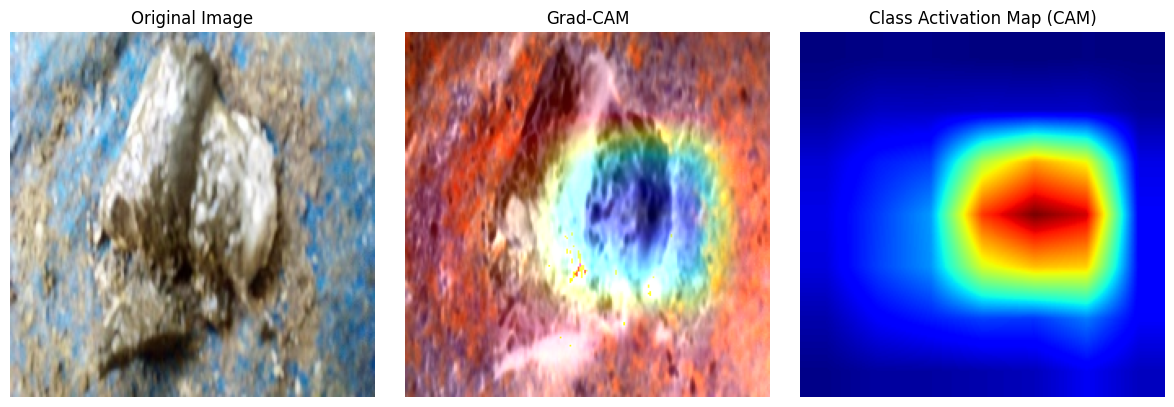

In [39]:
# Visualize Grad-CAM and CAM for a sample image (change the index as needed)
sample_index = 1  # Change this to the index of the image you want to visualize
sample_image = test_x[sample_index]
sample_true_label = test_y[sample_index]

# Create a sub-model that extracts the output of the final convolutional layer
last_conv_layer = model.get_layer('conv5_block3_2_relu')
grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

# Compute the gradient of the top predicted class with respect to the output feature map of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.expand_dims(sample_image, axis=0))
    loss = predictions[:, sample_true_label]

grads = tape.gradient(loss, conv_outputs)[0]
gradient_weights = tf.reduce_mean(grads, axis=(0, 1))

# Generate the CAM heatmap
cam = np.dot(conv_outputs[0], gradient_weights.numpy())

# Resize CAM to the original image size
cam = cv2.resize(cam, (sample_image.shape[1], sample_image.shape[0]))
cam = np.maximum(cam, 0)  # Apply ReLU to exclude negative values
cam = cam / cam.max()  # Normalize between 0 and 1

# Convert the CAM heatmap to a colormap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = heatmap * 0.4 + (sample_image * 255).astype(np.uint8)
superimposed_img = np.minimum(superimposed_img, 255).astype(np.uint8)

# Display the original image, Grad-CAM, and CAM
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(132)
plt.title('Grad-CAM')
plt.imshow(superimposed_img)
plt.axis('off')

plt.subplot(133)
plt.title('Class Activation Map (CAM)')
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

In [40]:
model.save('poultry1.h5')

In [43]:
model.save('my_model.keras')